In [ ]:
!pip install openpyxl
!pip install shap
!pip install scikit-learn
!pip install imbalanced-learn
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install tensorflow
!pip install seaborn --upgrade

In [ ]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

### Data Configuration

In [ ]:
df1 = pd.read_excel('C:/users/a.aybarf/Downloads/dfMLplp24.xlsx', index_col=0)

In [ ]:
len(df1)

91414

In [ ]:
df1.columns

Index(['plp', 'rururb', 'edad', 'sexo', 'alfabetism', 'trabajo_mp', 'ins_ali',
       'hli', 'segsoc', 'atemed', 'tarjeta', 'disp_elect', 'tot_resid',
       'región', 'conectividad', 'agua_drenaje', 'neducativojefe',
       'trabajomenores', 'niños', 'ocupacion_hogar', 'consumption_expenditure',
       'basic_energy', 'housing_tenure'],
      dtype='object')

In [ ]:
#df1 = df1.drop(['gasto_total_e','trabajo_mp','basic_energy', 'housing_tenure'], axis=1)
df1 = df1.drop(['trabajo_mp'], axis=1)

In [ ]:
df1.columns = ['plp',                 # Poverty Line Percentage",
    'urban_rural',         # 'rururb' = rural or urban\n",
    'age',                 # 'edad'\n",
    'sex',                 # 'sexo'\n",
    'literacy',            # 'alfabetism'\n",
    'food_insecurity',     # 'ins_ali' = food insecurity\n",
    'hli',                 # hli",
    'public_healthcare',   # social health insurance",
    'medical_attention',   # 'atemed'\n",
    'bank_card',           # 'tarjeta' = debit/credit/bank card\n",
    'electricity',  # 'disp_elect' = electronic devices availability\n",
    'total_residents',     # 'tot_resid'\n",
    'region',              # 'región'\n",
    'connectivity',        # 'conectividad' = internet or digital connectivity\n",
    'water_drainage',      # 'agua_drenaje'\n",
    'household_head_edu',  # 'neducativojefe' = educational level of household head\n",
    'child_labor',         # 'trabajomenores'\n",
    'children',            # 'niños'\n",
    'household_occupation', # 'ocupacion_hogar' = economic activity of the household\n",
    'consumption expenditure',
    'basic_energy_equipment',
    'housing_tenure'
   ]

In [ ]:
df1.columns

Index(['plp', 'urban_rural', 'age', 'sex', 'literacy', 'food_insecurity',
       'hli', 'public_healthcare', 'medical_attention', 'bank_card',
       'electricity', 'total_residents', 'region', 'connectivity',
       'water_drainage', 'household_head_edu', 'child_labor', 'children',
       'household_occupation', 'consumption expenditure',
       'basic_energy_equipment', 'housing_tenure'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils import resample

Matplotlib is building the font cache; this may take a moment.


In [ ]:
import joblib

In [ ]:
#Inicialización del método de muestreo por minorías sintéticas para el balanceo del conjunto de datos de entrenamiento a generar

os = SMOTE(random_state=0)

#División del conjunto de datos total en conjunto de entrenamiento y conjunto de prueba a través de la regla de Pareto: 80-20
X = df1[['urban_rural', 'age', 'sex', 'literacy',
       'food_insecurity', 'hli', 'public_healthcare', 'medical_attention',
       'bank_card', 'electricity', 'total_residents', 'region', 'connectivity',
       'water_drainage', 'household_head_edu', 'child_labor', 'children',
       'household_occupation', 'consumption expenditure',
       'basic_energy_equipment', 'housing_tenure',]]
y = df1[['plp']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(73131, 21) (73131, 1)
(18283, 21) (18283, 1)


In [ ]:
# Función para calcular el intervalo de confianza del AUC mediante bootstrap
def compute_auc_ci(y_true, y_scores, n_bootstraps=1000, alpha=0.95):
    rng = np.random.default_rng()  # Generador de números aleatorios
    bootstrapped_scores = []

    for _ in range(n_bootstraps):
        # Bootstrap: muestreo con reemplazo
        indices = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[indices])) < 2:  # Verifica que haya al menos dos clases
            continue
        score = auc(*roc_curve(y_true[indices], y_scores[indices])[:2])
        bootstrapped_scores.append(score)

    # Calcula los percentiles para el intervalo de confianza
    lower = np.percentile(bootstrapped_scores, (1 - alpha) / 2 * 100)
    upper = np.percentile(bootstrapped_scores, (1 + alpha) / 2 * 100)
    return lower, upper

# Modificar la función de la curva ROC para incluir el CI
def plot_roc_curve_with_ci(y_true, y_scores, title="ROC Curve", n_bootstraps=1000):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ci_lower, ci_upper = compute_auc_ci(np.array(y_true), np.array(y_scores), n_bootstraps=n_bootstraps)

    # Graficar la curva ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f}, 95% CI = [{ci_lower:.2f}, {ci_upper:.2f}])')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return roc_auc, ci_lower, ci_upper

In [ ]:
def plot_multi_roc_curves_with_ci(models_data, title="ROC Curves", label="a"):
    """
    Grafica múltiples curvas ROC con intervalos de confianza (95% CI).

    Parámetros:
        - models_data: Lista de tuplas [(modelo, y_true, y_scores, color, nombre del modelo)].
        - title: Título del gráfico.
        - label: Etiqueta en la parte superior izquierda del gráfico.
    """
    # Estilo limpio con fondo blanco
    plt.style.use('default')

    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_facecolor("white")  # Fondo blanco explícito para los ejes

    for model_data in models_data:
        y_true, y_scores, color, model_name = model_data

        # Calcula ROC y AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Calcula el intervalo de confianza del AUC
        ci_lower, ci_upper = compute_auc_ci(np.array(y_true), np.array(y_scores))

        # Agregar la curva al gráfico
        plt.plot(
            fpr,
            tpr,
            color=color,
            lw=2,
            label=f'{model_name} AUC={roc_auc:.3f} (CI: {ci_lower:.3f} - {ci_upper:.3f})'
        )

    # Línea diagonal gris discontinua
    plt.plot([0, 1], [0, 1], color='white', linestyle='--', lw=1.5)

     # Línea diagonal de referencia
    plt.plot(
        [0, 1], [0, 1],
        color='gray',
        linestyle='--',
        linewidth=1.5
    )

    # Configuración del gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title(title, fontsize=10)
    # Leyenda más compacta
    plt.legend(
        loc="lower right",
        fontsize=11,  # Tamaño de fuente más pequeño
        bbox_to_anchor=(1.0, 0.0),  # Ajustar la posición de la leyenda
        frameon=True,  # Habilitar el marco
        shadow=False,  # Sin sombra
        borderpad=0.5  # Espaciado interno del marco
    )

    # Etiqueta en la parte superior izquierda
    plt.text(-0.1, 1.05, label, fontsize=16, fontweight='bold', va='center', ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, Dense, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score
import time

### DL Testing

In [ ]:
# Split the data into training and test sets
X_train1, X_test1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #hacerle reshape a todo (train, test y validation)

X_train = X_train1.reset_index(drop=True)
y_train = y_train.reset_index(drop=True) #dividir a y_0 y y_1

Xtrainfinal1 = X_train.to_numpy()
ytrainfinal1 = y_train.to_numpy()
X_test1 = X_test1.to_numpy()
y_test1 = y_test.to_numpy()

X_test1=tf.reshape(X_test1,(X_test1.shape[0], X_test1.shape[1],1))

In [ ]:
# Initialize StratifiedKFold for 10-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
initial_learning_rate = 0.01
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=200, decay_rate=0.9)

In [ ]:
# Define the CNN model
def create_cnn_model(Xtrainfinal1):
    model = Sequential()
    # Capas convolucionales y de pooling
    model.add(Conv1D(filters=50, kernel_size=7, activation='relu', input_shape=(Xtrainfinal1.shape[1], Xtrainfinal1.shape[2]), padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=25, kernel_size=7, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=10, kernel_size=7, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Flatten())
    #Capas densas
    model.add(Dense(10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))  # Add dropout for regularization
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr_schedule), metrics=['accuracy']) #sparse_categorical_crossentropy (si es que no funciona la división de y con one-hot encoding)
    return model

In [ ]:
best_model = None
best_accuracy = 0.0
counter = 1
accuracyacumulada = 0.0

# Mide el tiempo de entrenamiento
start_time = time.time()
# Perform 10-fold cross-validation
for train_idx, val_idx in kfold.split(Xtrainfinal1, ytrainfinal1):

    dfX = pd.DataFrame(Xtrainfinal1, columns=X.columns)
    dfy = pd.DataFrame(ytrainfinal1, columns=y.columns)

    X_trainP, X_val = dfX.loc[train_idx], dfX.loc[val_idx]
    y_trainP, y_val = dfy.loc[train_idx], dfy.loc[val_idx]

    X_trainP = X_trainP.to_numpy()
    X_val = X_val.to_numpy()
    y_trainP = y_trainP.to_numpy()
    y_val = y_val.to_numpy()

    X_trainP=tf.reshape(X_trainP,(X_trainP.shape[0], X_trainP.shape[1],1))
    X_val=tf.reshape(X_val,(X_val.shape[0], X_val.shape[1],1))

    model = create_cnn_model(X_trainP)
    fold_start_time = time.time()
    history = model.fit(X_trainP, y_trainP, epochs=25, batch_size=128, validation_data=(X_val, y_val), verbose=0)
    fold_end_time = time.time()
    #history
    #(sacarlo primero del for para probar la arquitecutra y luego incluirlo)

    fold_duration = fold_end_time - fold_start_time
    print(f"Tiempo de entrenamiento del Fold {counter}: {fold_duration:.2f} segundos")

    # Evaluate the model on the validation set
    y_val_pred = model.predict(X_val)
    y_val_pred = (y_val_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f'Validation Accuracy {counter}: {accuracy * 100:.2f}%')

    counter += 1
    accuracyacumulada += accuracy

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_history = history
        bestcm = confusion_matrix(y_val, y_val_pred)
        best_precision = precision_score(y_val, y_val_pred)
        bestrecall = recall_score(y_val, y_val_pred)
        bestspecificity = bestcm[0, 0] / (bestcm[0, 0] + bestcm[0, 1])
        bestf1 = f1_score(y_val, y_val_pred)
        fpr, tpr, _ = roc_curve(y_val, y_val_pred)
        bestroc_auc = auc(fpr, tpr)


print(' ')
print(f'Average Validation Accuracy: {(accuracyacumulada/10) * 100:.2f}%')
end_time = time.time()

In [ ]:
# Calcula duración
training_time = end_time - start_time
print(f"Tiempo total de entrenamiento: {training_time:.2f} segundos")

In [ ]:
print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%')
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}%')
print(f'Best Validation AUC: {bestroc_auc:.2f}%')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Matriz de confusión estimada
conf_matrix = np.array([[929, 134],
       [308, 377]])  # [FP, TN]

# Reorganizar a formato: [[TP, FN], [FP, TN]]
# Pero para seaborn, la convención es: filas = reales, columnas = predichos
# Así que reorganizamos como:
# [[TP, FN],    --> Positivo real
#  [FP, TN]]    --> Negativo real

# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
plt.savefig('confusionmatrixRF.png')

plt.show()

In [ ]:
# Get the current learning rate from the optimizer
current_learning_rate = tf.keras.backend.get_value(model.optimizer.learning_rate)
print("Current Learning Rate:", current_learning_rate)

In [ ]:
import pydot
import graphviz
from tensorflow.keras.utils import plot_model

plot_model(best_model, to_file='prueba1_best_model_cnn_modelMODELOFINALv2.png', show_shapes=True)

In [ ]:
import matplotlib.pyplot as plt

# Plotting both training accuracy and loss in a single graph
plt.figure(figsize=(12, 6))

# Plot training accuracy and loss in the same graph
plt.plot(best_history.history['accuracy'], label='Train Accuracy')
plt.plot(best_history.history['loss'], label='Train Loss')

plt.title('Model Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend(loc='upper left')

# Save the plot to a file
plt.savefig('accuracy_loss_plot_best_modelMODELOFINALv2.png')

# Show the plot
plt.show()

In [ ]:
# Make predictions on the test set using the best model
y_test_pred = best_model.predict(X_test1)

y_test_pred = (y_test_pred > 0.5).astype(int)

# Evaluate the performance on the test set
test_accuracy = accuracy_score(y_test1, y_test_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion = confusion_matrix(y_test1, y_test_pred)
confusion

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixMODELOFINALv2.png')

plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test1, y_test_pred)
# Calculate accuracy
accuracy = accuracy_score(y_test1, y_test_pred)
# Calculate precision
precision = precision_score(y_test1, y_test_pred)
# Calculate recall (sensitivity)
recall = recall_score(y_test1, y_test_pred)
# Calculate specificity
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
# Calculate F1-score
f1 = f1_score(y_test1, y_test_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-score: {f1:.4f}")

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np

# Calcula el AUC y grafica la curva ROC
def plot_roc_curve(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    return roc_auc

# Evaluar AUC en el conjunto de validación y graficar para la última iteración del cross-validation
y_val_scores = best_model.predict(X_val).ravel()  # Probabilidades para el conjunto de validación
auc_val = plot_roc_curve(y_val, y_val_scores, title="ROC Curve (Validation Set)")

# Evaluar AUC en el conjunto de prueba
y_test_scores = best_model.predict(X_test1).ravel()  # Probabilidades para el conjunto de prueba
auc_test = plot_roc_curve(y_test1, y_test_scores, title="ROC Curve (Test Set)")

print(f'Validation AUC: {auc_val:.2f}')
print(f'Test AUC: {auc_test:.2f}')

### ML Testing

#### Logistic Regression

In [ ]:
#Logistic Regression

parameters = {'solver':['newton-cg','liblinear','sag','saga']}
clf_lr = GridSearchCV(LogisticRegression(), parameters, cv=10,n_jobs=-1,verbose=4)
clf_lr.fit(X_train, y_train)

In [ ]:
clf_lr.best_params_

In [ ]:
clf_lr.best_score_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = clf_lr.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
clf_lr.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(clf_lr.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
from sklearn.metrics import accuracy_score

bestcm = confusion_matrix(y_train, clf_lr.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, clf_lr.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, clf_lr.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, clf_lr.best_estimator_.predict(X_train))
bestspecificity = bestcm[0, 0] / (bestcm[0, 0] + bestcm[0, 1])
bestf1 = f1_score(y_train, clf_lr.best_estimator_.predict(X_train))
auclr = round(metrics.roc_auc_score(y_train, clf_lr.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%') #sensitivity
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}')
print(f'Best Validation AUC: {auclr:.2f}')

In [ ]:
print(classification_report(y_train,clf_lr.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestcm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixLRTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(clf_lr.best_estimator_, 'mejor_modeloLR.pkl')

In [ ]:
modeloLR = clf_lr.best_estimator_
predictionslr = modeloLR.predict(X_test)
targetlr=np.array(y_test)
confusionlr = confusion_matrix(targetlr, predictionslr)
print(confusionlr)

In [ ]:
# Calculate confusion matrix
cmlr = confusion_matrix(targetlr,predictionslr)
# Calculate accuracy
accuracylr = accuracy_score(targetlr,predictionslr)
# Calculate precision
precisionlr = precision_score(targetlr,predictionslr)
# Calculate recall (sensitivity)
recalllr = recall_score(targetlr,predictionslr)
# Calculate specificity
specificitylr = cmlr[0, 0] / (cmlr[0, 0] + cmlr[0, 1])
# Calculate F1-score
f1lr = f1_score(targetlr,predictionslr)

# Print the results
print(f"Accuracy: {accuracylr:.4f}")
print(f"Precision: {precisionlr:.4f}")
print(f"Recall (Sensitivity): {recalllr:.4f}")
print(f"Specificity: {specificitylr:.4f}")
print(f"F1-score: {f1lr:.4f}")

In [ ]:
print(classification_report(targetlr,predictionslr))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusionlr, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixLRTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, clf_lr.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'LR'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCLRTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetlr, modeloLR.predict_proba(X_test)[:, 1], 'red', 'LR'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCLRTest.png')

plt.show()

#### ERT

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [False, True],
    'criterion': ['gini', 'entropy']
}

grid_search_ert = GridSearchCV(ExtraTreesClassifier(), param_grid, cv=10,n_jobs=-1,verbose=4)
grid_search_ert.fit(X_train, y_train)

In [ ]:
grid_search_ert.best_params_

In [ ]:
grid_search_ert.best_score_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = grid_search_ert.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
grid_search_ert.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(grid_search_ert.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
bestcm = confusion_matrix(y_train, grid_search_ert.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, grid_search_ert.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, grid_search_ert.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, grid_search_ert.best_estimator_.predict(X_train))
bestspecificity = bestcm[0, 0] / (bestcm[0, 0] + bestcm[0, 1])
bestf1 = f1_score(y_train, grid_search_ert.best_estimator_.predict(X_train))
auclr = round(metrics.roc_auc_score(y_train, grid_search_ert.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%') #sensitivity
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}')
print(f'Best Validation AUC: {auclr:.2f}')

In [ ]:
print(classification_report(y_train,grid_search_ert.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestcm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
plt.savefig('confusionmatrixERTTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(grid_search_ert.best_estimator_, 'mejor_modeloERT.pkl')

In [ ]:
modeloERT = grid_search_ert.best_estimator_
predictionsERT = modeloERT.predict(X_test)
targetERT=np.array(y_test)
confusionERT = confusion_matrix(targetERT, predictionsERT)
print(confusionERT)

In [ ]:
# Calculate confusion matrix
cmERT = confusion_matrix(targetERT, predictionsERT)
# Calculate accuracy
accuracyERT = accuracy_score(targetERT, predictionsERT)
# Calculate precision
precisionERT = precision_score(targetERT, predictionsERT)
# Calculate recall (sensitivity)
recallERT = recall_score(targetERT, predictionsERT)
# Calculate specificity
specificityERT = cmERT[0, 0] / (cmERT[0, 0] + cmERT[0, 1])
# Calculate F1-score
f1ERT = f1_score(targetERT, predictionsERT)

# Print the results
print(f"Accuracy: {accuracyERT:.4f}")
print(f"Precision: {precisionERT:.4f}")
print(f"Recall (Sensitivity): {recallERT:.4f}")
print(f"Specificity: {specificityERT:.4f}")
print(f"F1-score: {f1ERT:.4f}")

In [ ]:
print(classification_report(targetERT,predictionsERT))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusionERT, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixERTTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, grid_search_ert.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'ERT'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
plt.savefig('CurvaROCERTTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetERT, modeloERT.predict_proba(X_test)[:, 1], 'red', 'ERT'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
plt.savefig('CurvaROCERTTest.png')

plt.show()

#### Decision Trees

In [ ]:
param_grid = {
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12],
    'criterion': ['gini', 'entropy']
}

grid_searchdt = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10,n_jobs=-1,verbose=4)
grid_searchdt.fit(X_train, y_train)

In [ ]:
grid_searchDT = grid_searchdt

In [ ]:
grid_searchDT.best_score_

In [ ]:
grid_searchDT.best_params_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = grid_searchDT.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
grid_searchDT.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(grid_searchDT.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
bestcm = confusion_matrix(y_train, grid_searchDT.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, grid_searchDT.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, grid_searchDT.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, grid_searchDT.best_estimator_.predict(X_train))
bestspecificity = bestcm[0, 0] / (bestcm[0, 0] + bestcm[0, 1])
bestf1 = f1_score(y_train, grid_searchDT.best_estimator_.predict(X_train))
aucrf = round(metrics.roc_auc_score(y_train, grid_searchDT.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%')
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}%')
print(f'Best Validation AUC: {aucrf:.2f}')

In [ ]:
print(classification_report(y_train,grid_searchDT.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestcm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixDTTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(grid_searchDT.best_estimator_, 'mejor_modeloDT.pkl')

In [ ]:
modeloDT = grid_searchDT.best_estimator_
predictionsDT = modeloDT.predict(X_test)
targetDT=np.array(y_test)
confusionDT = confusion_matrix(targetDT, predictionsDT)
print(confusionDT)

In [ ]:
# Calculate confusion matrix
cmDT = confusion_matrix(targetDT,predictionsDT)
# Calculate accuracy
accuracyDT = accuracy_score(targetDT,predictionsDT)
# Calculate precision
precisionDT = precision_score(targetDT,predictionsDT)
# Calculate recall (sensitivity)
recallDT = recall_score(targetDT,predictionsDT)
# Calculate specificity
specificityDT = cmDT[0, 0] / (cmDT[0, 0] + cmDT[0, 1])
# Calculate F1-score
f1DT = f1_score(targetDT,predictionsDT)

# Print the results
print(f"Accuracy: {accuracyDT:.4f}")
print(f"Precision: {precisionDT:.4f}")
print(f"Recall (Sensitivity): {recallDT:.4f}")
print(f"Specificity: {specificityDT:.4f}")
print(f"F1-score: {f1DT:.4f}")

In [ ]:
print(classification_report(targetDT,predictionsDT))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusionDT, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixDTTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, grid_searchDT.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'DT'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCDTTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetDT, modeloDT.predict_proba(X_test)[:, 1], 'red', 'DT'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCDTTest.png')

plt.show()

#### Random Forest

In [ ]:
param_grid = {
    'n_estimators': [100,110,120,130,140,150,160,170,180,190,200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,9,10,11,12],
    'criterion' :['gini', 'entropy']
}

grid_searchRF = GridSearchCV(RandomForestClassifier(), param_grid, cv=10,n_jobs=-1,verbose=4)
grid_searchRF.fit(X_train, y_train)

In [ ]:
grid_searchRF.best_score_

In [ ]:
grid_searchRF.best_params_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = grid_searchRF.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
grid_searchRF.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(grid_searchRF.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
bestrf = confusion_matrix(y_train, grid_searchRF.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, grid_searchRF.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, grid_searchRF.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, grid_searchRF.best_estimator_.predict(X_train))
bestspecificity = bestrf[0, 0] / (bestrf[0, 0] + bestrf[0, 1])
bestf1 = f1_score(y_train, grid_searchRF.best_estimator_.predict(X_train))
aucrf = round(metrics.roc_auc_score(y_train, grid_searchRF.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%')
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}%')
print(f'Best Validation AUC: {aucrf:.2f}')

In [ ]:
print(classification_report(y_train,grid_searchRF.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestrf, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixRFTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(grid_searchRF.best_estimator_, 'mejor_modeloRF.pkl')

In [ ]:
modeloRF = grid_searchRF.best_estimator_
predictionsRF = modeloRF.predict(X_test)
targetRF=np.array(y_test)
confusionRF = confusion_matrix(targetRF, predictionsRF)
print(confusionRF)

In [ ]:
# Calculate confusion matrix
cmRF = confusion_matrix(targetRF,predictionsRF)
# Calculate accuracy
accuracyRF = accuracy_score(targetRF,predictionsRF)
# Calculate precision
precisionRF = precision_score(targetRF,predictionsRF)
# Calculate recall (sensitivity)
recallRF = recall_score(targetRF,predictionsRF)
# Calculate specificity
specificityRF = cmRF[0, 0] / (cmRF[0, 0] + cmRF[0, 1])
# Calculate F1-score
f1RF = f1_score(targetRF,predictionsRF)

# Print the results
print(f"Accuracy: {accuracyRF:.4f}")
print(f"Precision: {precisionRF:.4f}")
print(f"Recall (Sensitivity): {recallRF:.4f}")
print(f"Specificity: {specificityRF:.4f}")
print(f"F1-score: {f1RF:.4f}")

In [ ]:
print(classification_report(targetRF,predictionsRF))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusionRF, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixRFTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, grid_searchRF.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'RF'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCRFTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetRF, modeloRF.predict_proba(X_test)[:, 1], 'red', 'RF'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCRFTest.png')

plt.show()

#### ANN

In [ ]:
parameters = {'max_iter': [250,500,750,1000], 'hidden_layer_sizes': np.arange(2,25,1), 'momentum':[0.4,0.5,0.6,0.7,0.8,0.9],'learning_rate_init':[0.1,0.5,0.01]}

clf_RNA = GridSearchCV(MLPClassifier(), parameters, cv=10,n_jobs=-1,verbose=4)
clf_RNA.fit(X_train, y_train)

In [ ]:
clf_RNA.best_params_

In [ ]:
clf_RNA.best_score_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = clf_RNA.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
clf_RNA.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(clf_RNA.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
bestann = confusion_matrix(y_train, clf_RNA.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, clf_RNA.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, clf_RNA.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, clf_RNA.best_estimator_.predict(X_train))
bestspecificity = bestann[0, 0] / (bestann[0, 0] + bestann[0, 1])
bestf1 = f1_score(y_train, clf_RNA.best_estimator_.predict(X_train))
auclr = round(metrics.roc_auc_score(y_train, clf_RNA.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%') #sensitivity
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}')
print(f'Best Validation AUC: {auclr:.2f}')

In [ ]:
print(classification_report(y_train,clf_RNA.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestcm, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixANNTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(clf_RNA.best_estimator_, 'mejor_modeloANN.pkl')

In [ ]:
modelNN = clf_RNA.best_estimator_
predictionsANN = modelNN.predict(X_test)
targetANN=np.array(y_test)
confusionANN = confusion_matrix(targetANN, predictionsANN)
print(confusionANN)

In [ ]:
# Calculate confusion matrix
cmAN = confusion_matrix(targetANN,predictionsANN)
# Calculate accuracy
accuracyAN = accuracy_score(targetANN,predictionsANN)
# Calculate precision
precisionAN = precision_score(targetANN,predictionsANN)
# Calculate recall (sensitivity)
recallAN= recall_score(targetANN,predictionsANN)
# Calculate specificity
specificityAN = cmAN[0, 0] / (cmAN[0, 0] + cmAN[0, 1])
# Calculate F1-score
f1AN = f1_score(targetANN,predictionsANN)

# Print the results
print(f"Accuracy: {accuracyAN:.4f}")
print(f"Precision: {precisionAN:.4f}")
print(f"Recall (Sensitivity): {recallAN:.4f}")
print(f"Specificity: {specificityAN:.4f}")
print(f"F1-score: {f1AN:.4f}")

In [ ]:
print(classification_report(targetANN,predictionsANN))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(confusionANN, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixANNTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, clf_RNA.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'ANN'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCANNTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetlr, clf_RNA.predict_proba(X_test)[:, 1], 'red', 'ANN'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCANNTest.png')

plt.show()

#### SVC

In [ ]:
from sklearn.svm import SVC

# Hiperparámetros más amplios y refinados
parameters = {
    'C': [0.01, 0.1, 1, 10],                 # Regularización: más valores grandes y pequeños
    'gamma': [0.001, 0.01, 0.1],  # Escalas automáticas + numéricos
    'kernel': ['linear', 'rbf']            # Se añade 'poly' si hay relaciones no lineales
}

clf_svm = GridSearchCV(SVC(probability=True), parameters, cv=10,n_jobs=-1,verbose=4)
clf_svm.fit(X_train, y_train)

In [ ]:
clf_svm.best_params_

In [ ]:
clf_svm.best_score_

In [ ]:
# Obtener todos los promedios de accuracy por combinación de parámetros
all_mean_accuracies = clf_svm.cv_results_['mean_test_score']

# Calcular el promedio general de esos promedios
overall_cv_accuracy = all_mean_accuracies.mean()

print(f"Accuracy promedio total de todos los CVs: {overall_cv_accuracy:.4f}")

In [ ]:
clf_svm.cv_results_['mean_fit_time']

In [ ]:
total_fit_time = sum(clf_svm.cv_results_['mean_fit_time']) * 10
print(f"Tiempo estimado total de entrenamiento: {total_fit_time:.2f} segundos")

In [ ]:
bestsvc = confusion_matrix(y_train, clf_svm.best_estimator_.predict(X_train))
best_accuracy = accuracy_score(y_train, clf_svm.best_estimator_.predict(X_train))
best_precision = precision_score(y_train, clf_svm.best_estimator_.predict(X_train))
bestrecall = recall_score(y_train, clf_svm.best_estimator_.predict(X_train))
bestspecificity = bestsvc[0, 0] / (bestsvc[0, 0] + bestsvc[0, 1])
bestf1 = f1_score(y_train, clf_svm.best_estimator_.predict(X_train))
auclr = round(metrics.roc_auc_score(y_train, clf_svm.best_estimator_.predict(X_train)), 4)

print(f'Best Validation Accuracy: {best_accuracy * 100:.2f}%')
print(f'Best Validation Precision: {best_precision * 100:.2f}%')
print(f'Best Validation Recall: {bestrecall * 100:.2f}%') #sensitivity
print(f'Best Validation Specificity: {bestspecificity * 100:.2f}%')
print(f'Best Validation F1: {bestf1:.2f}')
print(f'Best Validation AUC: {auclr:.2f}')

In [ ]:
print(classification_report(y_train,clf_svm.best_estimator_.predict(X_train)))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(bestsvc, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixSVCTrain.png')

plt.show()

In [ ]:
# Guardar el mejor modelo
joblib.dump(clf_svm.best_estimator_, 'mejor_modeloSVC.pkl')

In [ ]:
modeloSVC = clf_svm.best_estimator_
predictionsSVC = modeloSVC.predict(X_test)
targetSVC = np.array(y_test)
confusionSVC = confusion_matrix(targetSVC, predictionsSVC)
print(confusionSVC)

In [ ]:
# Calculate confusion matrix
cmSVC = confusion_matrix(targetSVC, predictionsSVC)
# Calculate accuracy
accuracySVC = accuracy_score(targetSVC, predictionsSVC)
# Calculate precision
precisionSVC = precision_score(targetSVC, predictionsSVC)
# Calculate recall (sensitivity)
recallSVC = recall_score(targetSVC, predictionsSVC)
# Calculate specificity
specificitySVC = cmSVC[0, 0] / (cmSVC[0, 0] + cmSVC[0, 1])
# Calculate F1-score
f1SVC = f1_score(targetSVC, predictionsSVC)

# Print the results
print(f"Accuracy: {accuracySVC:.4f}")
print(f"Precision: {precisionSVC:.4f}")
print(f"Recall (Sensitivity): {recallSVC:.4f}")
print(f"Specificity: {specificitySVC:.4f}")
print(f"F1-score: {f1SVC:.4f}")

In [ ]:
print(classification_report(targetSVC, predictionsSVC))

In [ ]:
# Visualize confusion matrix using seaborn
sns.set(font_scale=1.2)
plt.figure(figsize=(6, 6))
sns.heatmap(cmSVC, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 15}, xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix')

# Save the plot to a file
#plt.savefig('confusionmatrixSVCTest.png')

plt.show()

In [ ]:
#Train
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, clf_svm.best_estimator_.predict_proba(X_train)[:, 1], 'red', 'SVC'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCSVCTrain.png')

plt.show()

In [ ]:
#Test
models_data2 = [
    #(y_val, y_val_scores, 'purple', "1D-CNN"),
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetSVC, modeloSVC.predict_proba(X_test)[:, 1], 'red', 'SVC'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvaROCSVCTest.png')

plt.show()

### ROC Curves

In [ ]:
# Ejemplo de uso (sustituir con tus datos reales)
models_data2 = [
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (y_train, modeloLR.predict_proba(X_train)[:, 1], 'red', 'LR'),
    (y_train, modeloRF.predict_proba(X_train)[:, 1], 'blue', 'RF'),
    (y_train, modeloDT.predict_proba(X_train)[:, 1], 'orange', 'DT'),
    (y_train, modeloERT.predict_proba(X_train)[:, 1], 'yellow', 'ERT'),
    (y_train, modeloSVC.predict_proba(X_train)[:, 1], 'green', 'SVC'),
    (y_train, modeloANN.predict_proba(X_train)[:, 1], 'purple', 'ANN'),
    (y_train, modeloAdaboost.predict_proba(X_train)[:, 1], 'black', 'Adaboost'),
]

plot_multi_roc_curves_with_ci(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
plt.savefig('CurvasROCTrain.png')

plt.show()

In [ ]:
# Obtener las probabilidades predichas (no binarizadas)
y_test_pred_probs = best_model.predict(X_test1).ravel()

In [ ]:
# Modificamos la función para incluir el cálculo del AUC con CI
def plot_multi_roc_curves_with_ci2(models_data, title="ROC Curves", label="a", n_bootstraps=1000):
    """
    Graficar múltiples curvas ROC con intervalos de confianza (95% CI).

    Parámetros:
        - models_data: Lista de tuplas [(y_true, y_scores, color, nombre del modelo)].
        - title: Título del gráfico.
        - label: Etiqueta en la parte superior izquierda del gráfico.
        - n_bootstraps: Número de muestras bootstrap para calcular el CI del AUC.
    """
    # Estilo limpio con fondo blanco
    plt.style.use('default')

    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.set_facecolor("white")  # Fondo blanco explícito para los ejes

    for model_data in models_data:
        y_true, y_scores, color, model_name = model_data

        # Calcula ROC y AUC
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)

        # Calcula el intervalo de confianza del AUC
        ci_lower, ci_upper = compute_auc_ci(np.array(y_true), np.array(y_scores), n_bootstraps=n_bootstraps)

        # Agregar la curva al gráfico
        plt.plot(
            fpr,
            tpr,
            color=color,
            lw=2,
            label=f'{model_name} AUC={roc_auc:.3f} (CI: {ci_lower:.3f} - {ci_upper:.3f})'
        )

    # Línea diagonal gris discontinua
    plt.plot([0, 1], [0, 1], color='white', linestyle='--', lw=1.5)

     # Línea diagonal de referencia
    plt.plot(
        [0, 1], [0, 1],
        color='gray',
        linestyle='--',
        linewidth=1.5
    )

    # Configuración del gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    plt.title(title, fontsize=10)
    # Leyenda más compacta
    plt.legend(
        loc="lower right",
        fontsize=11,  # Tamaño de fuente más pequeño
        bbox_to_anchor=(1.0, 0.0),  # Ajustar la posición de la leyenda
        frameon=True,  # Habilitar el marco
        shadow=False,  # Sin sombra
        borderpad=0.5  # Espaciado interno del marco
    )

    # Etiqueta en la parte superior izquierda
    plt.text(-0.1, 1.05, label, fontsize=16, fontweight='bold', va='center', ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
# Ejemplo de uso (sustituir con tus datos reales)
models_data2 = [
    # Agregar más modelos si es necesario: (y_true, y_scores, color, nombre del modelo)
    (targetlr, modeloLR.predict_proba(X_test)[:, 1], 'red', 'LR'),
    (targetRF, modeloRF.predict_proba(X_test)[:, 1], 'blue', 'RF'),
    (targetDT, modeloDT.predict_proba(X_test)[:, 1], 'orange', 'DT'),
    (targetERT, modeloERT.predict_proba(X_test)[:, 1], 'yellow', 'ERT'),
    (targetSVC, modeloSVC.predict_proba(X_test)[:, 1], 'green', 'SVC'),
    (targetANN, modelNN.predict_proba(X_test)[:, 1], 'purple', 'ANN')
]

# Agregar a la lista de modelos
models_data2.append(
    (y_test1, y_test_pred_probs, 'cyan', '1D-CNN')
)


plot_multi_roc_curves_with_ci2(models_data2, title="ROC Curves", label="a")

# Save the plot to a file
#plt.savefig('CurvasROCTest.png')

plt.show()

### Comparación de métricas de bondad de ajuste

#### DeLong Test for AUC

In [ ]:
from MLstatkit.stats import Delong_test
import numpy as np

In [ ]:
# Lista de modelos (con sus etiquetas y probabilidades)
models_data2 = [
    (targetlr, modeloLR.predict_proba(X_test)[:, 1], 'red', 'LR'),
    (targetRF, modeloRF.predict_proba(X_test)[:, 1], 'blue', 'RF'),
    (targetDT, modeloDT.predict_proba(X_test)[:, 1], 'orange', 'DT'),
    (targetERT, modeloERT.predict_proba(X_test)[:, 1], 'yellow', 'ERT'),
    (targetSVC, modeloSVC.predict_proba(X_test)[:, 1], 'green', 'SVC'),
    (targetANN, modelNN.predict_proba(X_test)[:, 1], 'purple', 'ANN')
]

models_data2.append((y_test1, y_test_pred_probs, 'cyan', '1D-CNN'))

# Realiza la prueba de DeLong para todas las combinaciones de modelos
for i in range(len(models_data2)):
    for j in range(i + 1, len(models_data2)):
        # Extrae los datos de los modelos i y j
        y_true_1, prob_1, color_1, model_name_1 = models_data2[i]
        y_true_2, prob_2, color_2, model_name_2 = models_data2[j]

        # Asegúrate de que los datos sean arrays 1D
        y_true_1 = np.array(y_true_1).flatten()
        y_true_2 = np.array(y_true_2).flatten()
        prob_1 = np.array(prob_1).flatten()
        prob_2 = np.array(prob_2).flatten()

        # Realiza la prueba de DeLong
        z, p, ci_LR, ci_RF, auc_LR, auc_RF, info = Delong_test(
            y_true_1, prob_1, prob_2,
            alpha=0.95, return_ci=True, return_auc=True, verbose=1
        )

        # Imprime los resultados
        print(f"Comparación: {model_name_1} vs {model_name_2}")
        print(f"Method   : {info['method']}")
        print(f"AUC_{model_name_1}    : {auc_LR * 100:.1f}, CI_{model_name_1} = {ci_LR}")
        print(f"AUC_{model_name_2}    : {auc_RF * 100:.1f}, CI_{model_name_2} = {ci_RF}")
        print(f"z-score  : {z:.3f}, p-value = {p:.3e}")
        print("-" * 50)

#### Wilcoxon Test for accuracy

In [ ]:
from scipy.stats import wilcoxon
import itertools
import numpy as np

In [ ]:
accuracy_modeloANN = (y_test.iloc[:, 0].values == predictionsANN).astype(int)
accuracy_modeloLR = (y_test.iloc[:, 0].values == predictionslr).astype(int)
accuracy_modeloRF = (y_test.iloc[:, 0].values == predictionsRF).astype(int)
accuracy_modeloDT = (y_test.iloc[:, 0].values == predictionsDT).astype(int)
accuracy_modeloERT = (y_test.iloc[:, 0].values == predictionsERT).astype(int)
accuracy_modeloSVC = (y_test.iloc[:, 0].values == predictionsSVC).astype(int)
accuracy_modelo1DCNN = (y_test_pred.flatten().astype(np.int64) == y_test1.flatten()).astype(int)

In [ ]:
# List of all accuracies
accuracies = {
    'ANN': accuracy_modeloANN,
    'LR': accuracy_modeloLR,
    'RF': accuracy_modeloRF,
    'DT': accuracy_modeloDT,
    'ERT': accuracy_modeloERT,
    'SVC': accuracy_modeloSVC,
    '1D-CNN': accuracy_modelo1DCNN
}

In [ ]:
# Generando todas las combinaciones posibles de modelos para hacer la comparación
combinations = itertools.combinations(accuracies.keys(), 2)

# Comparando cada par de modelos con el test de Wilcoxon
for model1, model2 in combinations:
    # Aplicando el test de Wilcoxon entre los modelos
    stat, p_value = wilcoxon(accuracies[model1], accuracies[model2])
    print(f"Comparando {model1} vs {model2}")
    print(f"Estadístico de Wilcoxon: {stat}")
    print(f"Valor p: {p_value}\n")

### Shapley Values

In [ ]:
# Convertir el tensor de TensorFlow a un array de NumPy
X_test_reshaped = X_test1.numpy()

In [ ]:
# Paso 2: Inicializar el explainer SHAP
explainer = shap.DeepExplainer(best_model, X_test_reshaped)

In [ ]:
# Calcular los valores SHAP para las primeras n muestras
shap_values = explainer.shap_values(X_test_reshaped)

In [ ]:
# Asegúrate de que los shap_values sean bidimensionales
shap_values2 = shap_values.reshape(shap_values.shape[0], -1)

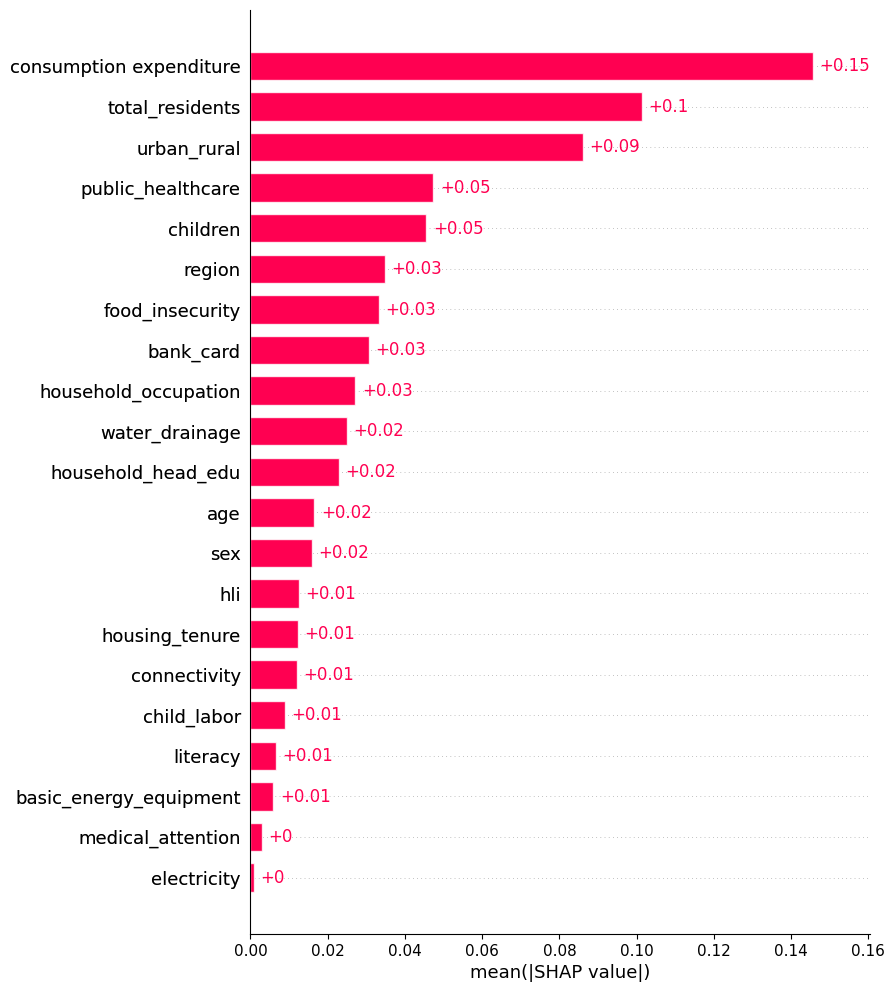

In [ ]:
explanation= shap.Explanation(values=shap_values2,
                             data=X_test_reshaped,
                             feature_names=X.columns)
shap.plots.bar(explanation, max_display=21)

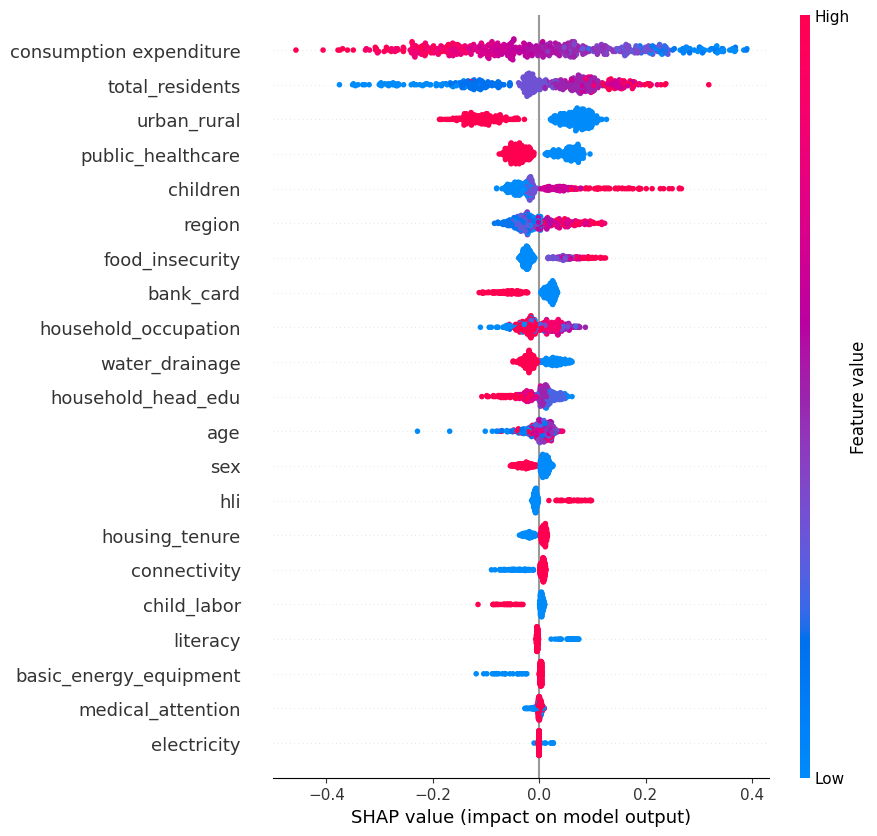

In [ ]:
# Crear el objeto Explanation para SHAP
explanation = shap.Explanation(values=shap_values2,
                                data=X_sample,
                                feature_names=X.columns)

# Crear el Beeswarm Plot
shap.plots.beeswarm(explanation, max_display=21)

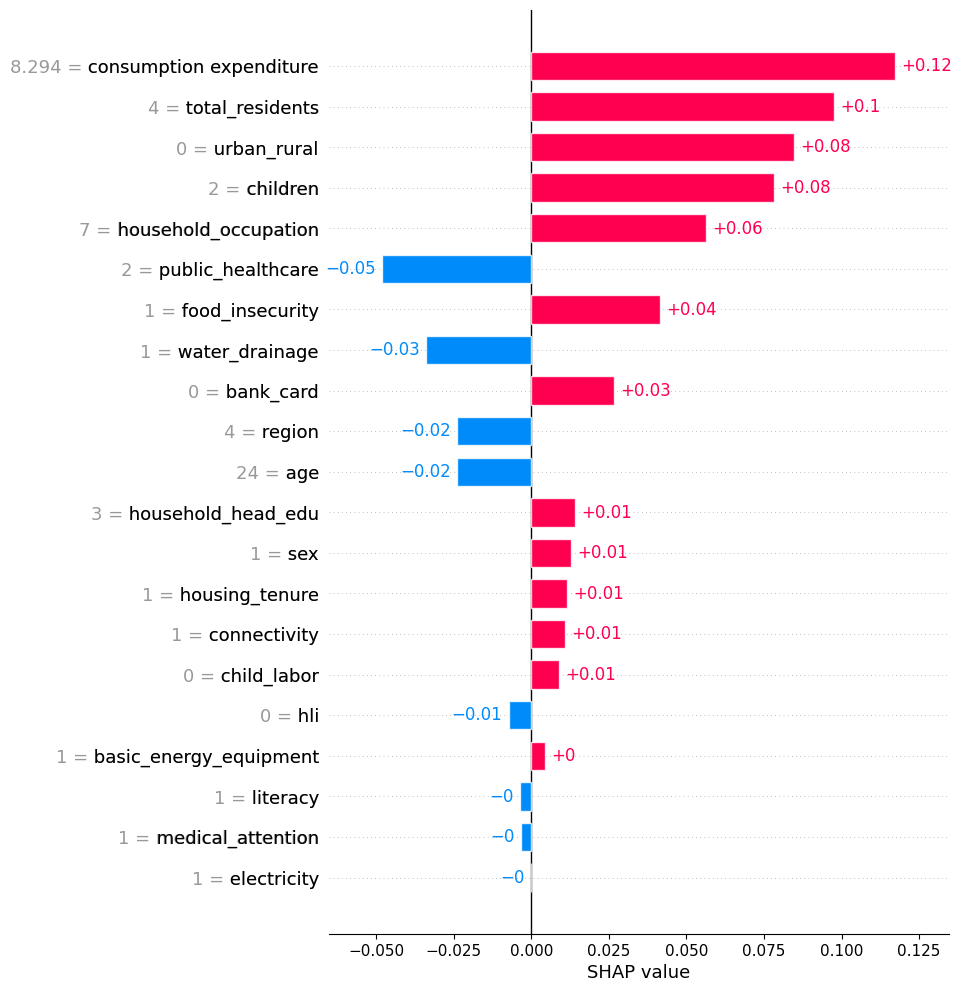

In [ ]:
shap.plots.bar(explanation[0], max_display=21) #Poor

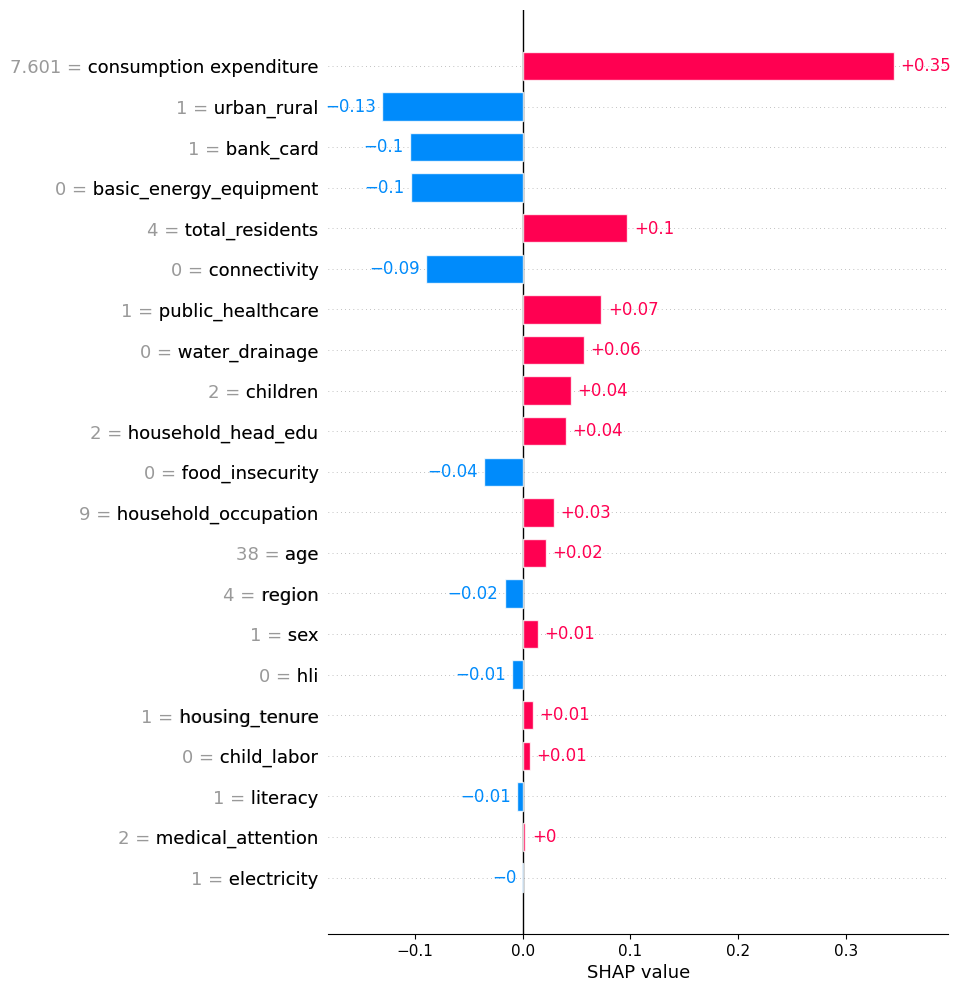

In [ ]:
shap.plots.bar(explanation[1], max_display=21) #Not Poor